In [1]:
# from sklearn.datasets import make_multilabel_classification
from torch.utils.data import Dataset
import json
import numpy as np
import torch
import time
from tqdm import tqdm

from preprocessing import for_train

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X, y = for_train("coauthor")

delet some useless data: 100%|██████████| 25793/25793 [00:00<00:00, 444025.41it/s]


Number of instance with label :  7460
Number of instance without label(remain) :  1894


authors: 100%|██████████| 25793/25793 [00:03<00:00, 7397.45it/s] 


In [3]:
print(X.shape)

N_FEATURES = X.shape[1]

torch.Size([9354, 21146])


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

print("Train:")
print("     X_train : ", X_train.shape)
print("     y_train : ", y_train.shape)
print("Test_Kaggle:")
print("     X_test  : ", X_test.shape)
print("     y_test  : ", y_test.shape)


Train:
     X_train :  torch.Size([7483, 21146])
     y_train :  torch.Size([7483, 100])
Test_Kaggle:
     X_test  :  torch.Size([1871, 21146])
     y_test  :  torch.Size([1871, 100])


In [5]:
from NN_Models import *

In [6]:
print(f"[INFO]: Number of training samples: {X_train.shape[0]}")
print(f"[INFO]: Number of training features: {X_train.shape[1]}")

# train data loader
train_dataset, train_dataloader = BinaryDataLoader(X_train, y_train, shuffle=True, batch_size=100)

# initialize the model
model = NeuralNetworkCoauthor()

[INFO]: Number of training samples: 7483
[INFO]: Number of training features: 21146


In [7]:
import torch.optim as optim

# learning parameters
optimizer = optim.Adam(params=model.parameters(), lr=0.001) # 学习率衰减 / 学习率震荡
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 100

# load the model on to the computation device
model.to(device)

NeuralNetworkCoauthor(
  (fc1): Linear(in_features=21146, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=100, bias=True)
)

In [8]:
import torch

# start the training
start = time.time()
train_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, train_dataloader, optimizer, loss_fn, train_dataset, device
    )
    train_loss.append(train_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
torch.save(model.state_dict(), 'status/model_authors.pth')

print("="*25)
print(time.time()-start, 's')

Epoch 1 of 100


  0%|          | 0/74 [00:00<?, ?it/s]/Users/messifr/Desktop/Messi/MasterY1S2/sml/COMP90051_Project2/code/multi_layer_models/NN_Models.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features, dtype=torch.float32)
/Users/messifr/Desktop/Messi/MasterY1S2/sml/COMP90051_Project2/code/multi_layer_models/NN_Models.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_dict[key] = torch.tensor(labels[i], dtype=torch.float32)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. 

Train Loss: 0.1901
Epoch 2 of 100


75it [00:35,  2.13it/s]                        


Train Loss: 0.0621
Epoch 3 of 100


75it [00:38,  1.97it/s]                        


Train Loss: 0.0543
Epoch 4 of 100


75it [00:38,  1.92it/s]                        


Train Loss: 0.0528
Epoch 5 of 100


75it [00:41,  1.80it/s]                        


Train Loss: 0.0512
Epoch 6 of 100


75it [00:39,  1.92it/s]                        


Train Loss: 0.0468
Epoch 7 of 100


75it [00:38,  1.96it/s]                        


Train Loss: 0.0373
Epoch 8 of 100


75it [00:37,  1.98it/s]                        


Train Loss: 0.0251
Epoch 9 of 100


75it [00:37,  2.01it/s]                        


Train Loss: 0.0161
Epoch 10 of 100


75it [00:44,  1.69it/s]                        


Train Loss: 0.0112
Epoch 11 of 100


75it [00:43,  1.71it/s]                        


Train Loss: 0.0089
Epoch 12 of 100


75it [00:42,  1.75it/s]                        


Train Loss: 0.0074
Epoch 13 of 100


75it [00:39,  1.92it/s]                        


Train Loss: 0.0065
Epoch 14 of 100


75it [00:39,  1.92it/s]                        


Train Loss: 0.0061
Epoch 15 of 100


75it [00:42,  1.78it/s]                        


Train Loss: 0.0057
Epoch 16 of 100


75it [00:43,  1.71it/s]                        


Train Loss: 0.0054
Epoch 17 of 100


75it [00:46,  1.62it/s]                        


Train Loss: 0.0051
Epoch 18 of 100


75it [00:44,  1.69it/s]                        


Train Loss: 0.0050
Epoch 19 of 100


75it [00:41,  1.82it/s]                        


Train Loss: 0.0049
Epoch 20 of 100


75it [00:41,  1.82it/s]                        


Train Loss: 0.0048
Epoch 21 of 100


75it [00:39,  1.92it/s]                        


Train Loss: 0.0048
Epoch 22 of 100


75it [00:46,  1.61it/s]                        


Train Loss: 0.0047
Epoch 23 of 100


75it [00:42,  1.78it/s]                        


Train Loss: 0.0047
Epoch 24 of 100


75it [00:43,  1.72it/s]                        


Train Loss: 0.0047
Epoch 25 of 100


75it [00:41,  1.82it/s]                        


Train Loss: 0.0046
Epoch 26 of 100


75it [00:40,  1.85it/s]                        


Train Loss: 0.0046
Epoch 27 of 100


75it [00:40,  1.85it/s]                        


Train Loss: 0.0046
Epoch 28 of 100


75it [00:40,  1.85it/s]                        


Train Loss: 0.0045
Epoch 29 of 100


75it [00:40,  1.84it/s]                        


Train Loss: 0.0045
Epoch 30 of 100


75it [00:40,  1.84it/s]                        


Train Loss: 0.0045
Epoch 31 of 100


75it [00:40,  1.85it/s]                        


Train Loss: 0.0045
Epoch 32 of 100


75it [00:40,  1.86it/s]                        


Train Loss: 0.0045
Epoch 33 of 100


75it [00:40,  1.83it/s]                        


Train Loss: 0.0045
Epoch 34 of 100


75it [00:40,  1.85it/s]                        


Train Loss: 0.0045
Epoch 35 of 100


75it [00:40,  1.84it/s]                        


Train Loss: 0.0045
Epoch 36 of 100


75it [00:40,  1.85it/s]                        


Train Loss: 0.0044
Epoch 37 of 100


75it [00:40,  1.84it/s]                        


Train Loss: 0.0045
Epoch 38 of 100


75it [00:40,  1.85it/s]                        


Train Loss: 0.0045
Epoch 39 of 100


75it [00:40,  1.85it/s]                        


Train Loss: 0.0045
Epoch 40 of 100


75it [00:40,  1.85it/s]                        


Train Loss: 0.0044
Epoch 41 of 100


75it [00:40,  1.85it/s]                        


Train Loss: 0.0044
Epoch 42 of 100


75it [00:40,  1.86it/s]                        


Train Loss: 0.0044
Epoch 43 of 100


75it [00:44,  1.69it/s]                        


Train Loss: 0.0044
Epoch 44 of 100


75it [00:42,  1.76it/s]                        


Train Loss: 0.0044
Epoch 45 of 100


75it [00:42,  1.77it/s]                        


Train Loss: 0.0044
Epoch 46 of 100


75it [00:41,  1.82it/s]                        


Train Loss: 0.0044
Epoch 47 of 100


75it [00:43,  1.74it/s]                        


Train Loss: 0.0044
Epoch 48 of 100


75it [00:38,  1.94it/s]                        


Train Loss: 0.0044
Epoch 49 of 100


75it [00:38,  1.95it/s]                        


Train Loss: 0.0044
Epoch 50 of 100


75it [00:39,  1.92it/s]                        


Train Loss: 0.0044
Epoch 51 of 100


75it [00:40,  1.86it/s]                        


Train Loss: 0.0043
Epoch 52 of 100


75it [00:40,  1.85it/s]                        


Train Loss: 0.0043
Epoch 53 of 100


75it [00:40,  1.84it/s]                        


Train Loss: 0.0043
Epoch 54 of 100


75it [00:41,  1.82it/s]                        


Train Loss: 0.0043
Epoch 55 of 100


75it [00:45,  1.65it/s]                        


Train Loss: 0.0043
Epoch 56 of 100


75it [00:42,  1.77it/s]                        


Train Loss: 0.0044
Epoch 57 of 100


75it [00:41,  1.81it/s]                        


Train Loss: 0.0043
Epoch 58 of 100


75it [00:39,  1.89it/s]                        


Train Loss: 0.0043
Epoch 59 of 100


75it [00:39,  1.90it/s]                        


Train Loss: 0.0043
Epoch 60 of 100


75it [00:39,  1.92it/s]                        


Train Loss: 0.0043
Epoch 61 of 100


75it [00:40,  1.87it/s]                        


Train Loss: 0.0043
Epoch 62 of 100


75it [00:39,  1.90it/s]                        


Train Loss: 0.0043
Epoch 63 of 100


75it [00:39,  1.90it/s]                        


Train Loss: 0.0043
Epoch 64 of 100


75it [00:38,  1.95it/s]                        


Train Loss: 0.0043
Epoch 65 of 100


75it [00:39,  1.91it/s]                        


Train Loss: 0.0043
Epoch 66 of 100


75it [00:38,  1.93it/s]                        


Train Loss: 0.0043
Epoch 67 of 100


75it [00:38,  1.94it/s]                        


Train Loss: 0.0043
Epoch 68 of 100


75it [00:38,  1.93it/s]                        


Train Loss: 0.0043
Epoch 69 of 100


75it [00:38,  1.93it/s]                        


Train Loss: 0.0042
Epoch 70 of 100


75it [00:37,  1.98it/s]                        


Train Loss: 0.0043
Epoch 71 of 100


75it [00:39,  1.88it/s]                        


Train Loss: 0.0043
Epoch 72 of 100


75it [00:39,  1.90it/s]                        


Train Loss: 0.0043
Epoch 73 of 100


75it [00:40,  1.84it/s]                        


Train Loss: 0.0042
Epoch 74 of 100


75it [00:38,  1.93it/s]                        


Train Loss: 0.0043
Epoch 75 of 100


75it [00:42,  1.76it/s]                        


Train Loss: 0.0042
Epoch 76 of 100


75it [00:40,  1.83it/s]                        


Train Loss: 0.0043
Epoch 77 of 100


75it [00:40,  1.85it/s]                        


Train Loss: 0.0042
Epoch 78 of 100


75it [00:39,  1.88it/s]                        


Train Loss: 0.0042
Epoch 79 of 100


75it [00:39,  1.91it/s]                        


Train Loss: 0.0042
Epoch 80 of 100


75it [00:40,  1.85it/s]                        


Train Loss: 0.0042
Epoch 81 of 100


75it [00:39,  1.91it/s]                        


Train Loss: 0.0042
Epoch 82 of 100


75it [00:40,  1.87it/s]                        


Train Loss: 0.0042
Epoch 83 of 100


75it [00:37,  2.00it/s]                        


Train Loss: 0.0042
Epoch 84 of 100


75it [00:40,  1.87it/s]                        


Train Loss: 0.0042
Epoch 85 of 100


75it [00:39,  1.91it/s]                        


Train Loss: 0.0042
Epoch 86 of 100


75it [00:37,  1.99it/s]                        


Train Loss: 0.0042
Epoch 87 of 100


75it [00:38,  1.93it/s]                        


Train Loss: 0.0042
Epoch 88 of 100


75it [00:39,  1.92it/s]                        


Train Loss: 0.0042
Epoch 89 of 100


75it [00:40,  1.84it/s]                        


Train Loss: 0.0042
Epoch 90 of 100


75it [00:40,  1.87it/s]                        


Train Loss: 0.0042
Epoch 91 of 100


75it [00:39,  1.88it/s]                        


Train Loss: 0.0042
Epoch 92 of 100


75it [00:40,  1.84it/s]                        


Train Loss: 0.0042
Epoch 93 of 100


75it [00:43,  1.71it/s]                        


Train Loss: 0.0042
Epoch 94 of 100


75it [00:43,  1.71it/s]                        


Train Loss: 0.0042
Epoch 95 of 100


75it [00:40,  1.85it/s]                        


Train Loss: 0.0041
Epoch 96 of 100


75it [00:40,  1.87it/s]                        


Train Loss: 0.0041
Epoch 97 of 100


75it [00:39,  1.89it/s]                        


Train Loss: 0.0042
Epoch 98 of 100


75it [00:40,  1.86it/s]                        


Train Loss: 0.0042
Epoch 99 of 100


75it [00:40,  1.87it/s]                        


Train Loss: 0.0042
Epoch 100 of 100


75it [00:41,  1.82it/s]                        


Train Loss: 0.0041
4069.337558031082 s


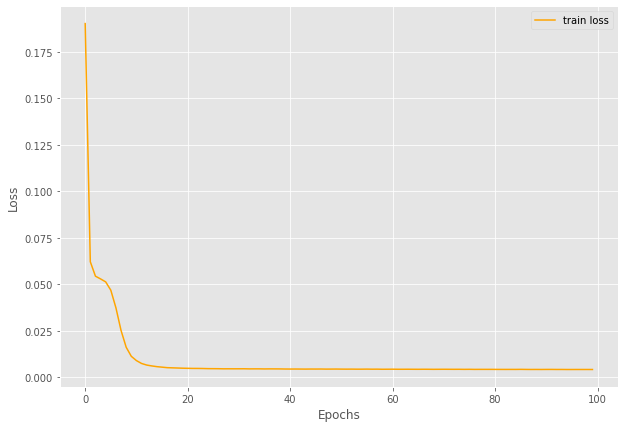

In [9]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

# plot and save the train loss graph
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('outputs/multi_head_binary_loss.png')
plt.show()

In [10]:
# print some info
print(f"[INFO]: Number of testing samples: {X_test.shape[0]}")
print(f"[INFO]: Number of testing features: {X_test.shape[1]}")

# train data loader
test_dataset, test_dataloader = BinaryDataLoader(X_test, y_test, shuffle=False, batch_size=1)

[INFO]: Number of testing samples: 1871
[INFO]: Number of testing features: 21146


In [11]:
model = NeuralNetworkCoauthor()
model.load_state_dict(torch.load('status/model_authors.pth'))
model.to(device)
model.eval()

NeuralNetworkCoauthor(
  (fc1): Linear(in_features=21146, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=100, bias=True)
)

In [12]:
from preprocessing import *

target_list = transform_labels(y_test, threshold=1)

In [13]:
from sklearn.metrics import accuracy_score, recall_score, f1_score

def get_f1(threshold):
    predict_list = []

    for i, test_sample in enumerate(test_dataloader):
        
        features = test_sample['features']
        
        
        features = torch.reshape(features, (features.shape[0], 1, features.shape[1])).to(device)
        
        outputs = model(features)
        
        outputs = outputs.squeeze()
                
        # get all the labels
        predict_list.append(transform_to_label(outputs, threshold=threshold))

    return predict_list, f1_score(target_list, predict_list, average='weighted')

In [14]:
thresholds = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
f1_scores = []

for i in tqdm(range(len(thresholds))):
    threshold = thresholds[i]

    predict_list, f1 = get_f1(threshold)

    f1_scores.append(f1)

  0%|          | 0/9 [00:00<?, ?it/s]/Users/messifr/Desktop/Messi/MasterY1S2/sml/COMP90051_Project2/code/multi_layer_models/NN_Models.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features, dtype=torch.float32)
/Users/messifr/Desktop/Messi/MasterY1S2/sml/COMP90051_Project2/code/multi_layer_models/NN_Models.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_dict[key] = torch.tensor(labels[i], dtype=torch.float32)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. U

In [15]:
THRESHOLD = thresholds[f1_scores.index(max(f1_scores))]
THRESHOLD

0.5

In [16]:
f1_scores

[0.5822524781759967,
 0.597699528018315,
 0.610946988768832,
 0.6135206014189415,
 0.6213495850455588,
 0.6250820329062303,
 0.6320668830279346,
 0.6333322531177583,
 0.6328967928093832]

# Kaggle Predictions

In [18]:
from preprocessing import for_kaggle

X_kaggle = for_kaggle('coauthor')

# print some info
print(f"[INFO]: Number of testing samples: {X_kaggle.shape[0]}")
print(f"[INFO]: Number of testing features: {X_kaggle.shape[1]}")

# train data loader
kaggle_dataloader = BinaryDataLoader(X_kaggle, None, shuffle=False, batch_size=1)

predict_dict = {}

# for i, test_sample in tqdm(enumerate(kaggle_dataloader), total=len(kaggle_dataloader)):
key = 0
for test_sample in tqdm(X_kaggle):
    # print(f"SAMPLE {i}")
    # extract the features and labels
    features = test_sample
    
    outputs = model(features)
    outputs = outputs.squeeze()
    tmp = {}
    
    for i in range(100):
        tmp[i] = outputs[i].item()
         
    predict_dict[key] = tmp
    
    key += 1

with open('outputs/author.json', 'w') as fp:
    json.dump(predict_dict, fp)

authors: 100%|██████████| 800/800 [00:00<00:00, 14283.40it/s]


[INFO]: Number of testing samples: 800
[INFO]: Number of testing features: 21146


  0%|          | 0/800 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 800/800 [00:04<00:00, 187.53it/s]
